# 02. Neural Network Classification with PyTorch

Online book of course: <https://www.learnpytorch.io/02_pytorch_classification/>

All other Resources: <https://github.com/mrdbourke/pytorch-deep-learning>

Classification = a proflem of predicting whether something is one thing or another (there can be multiple things as the options)

Classification problems is one of the main problems of machine learning

Examples of Classifications
* Binary Classification = One thing or another (1 or 0)
* Multiclass Classification = more than one thing or another
* Multilabel Classification = Multiple label options per sample
* and so on... 

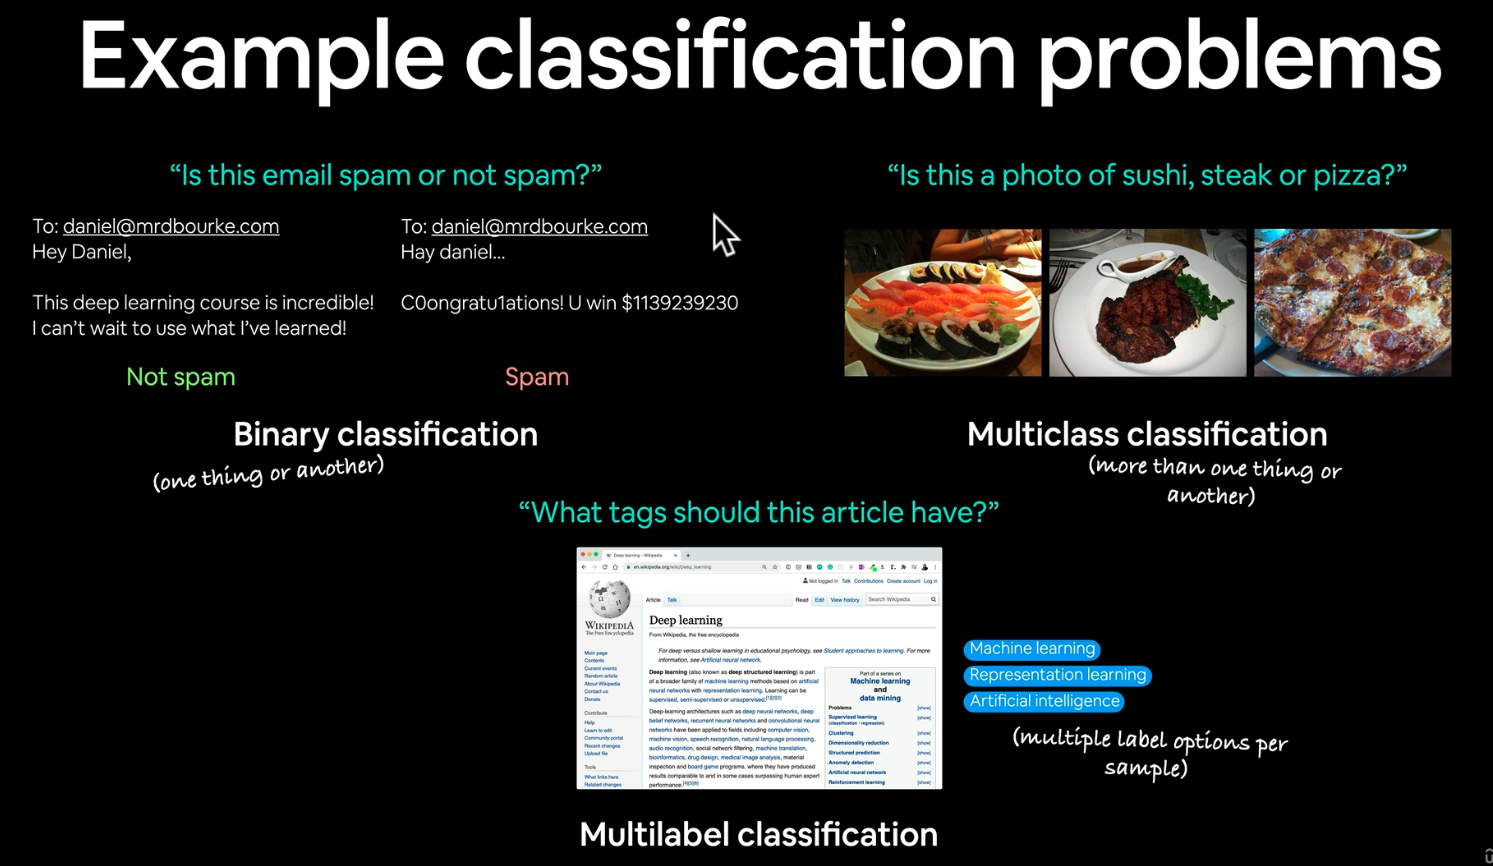

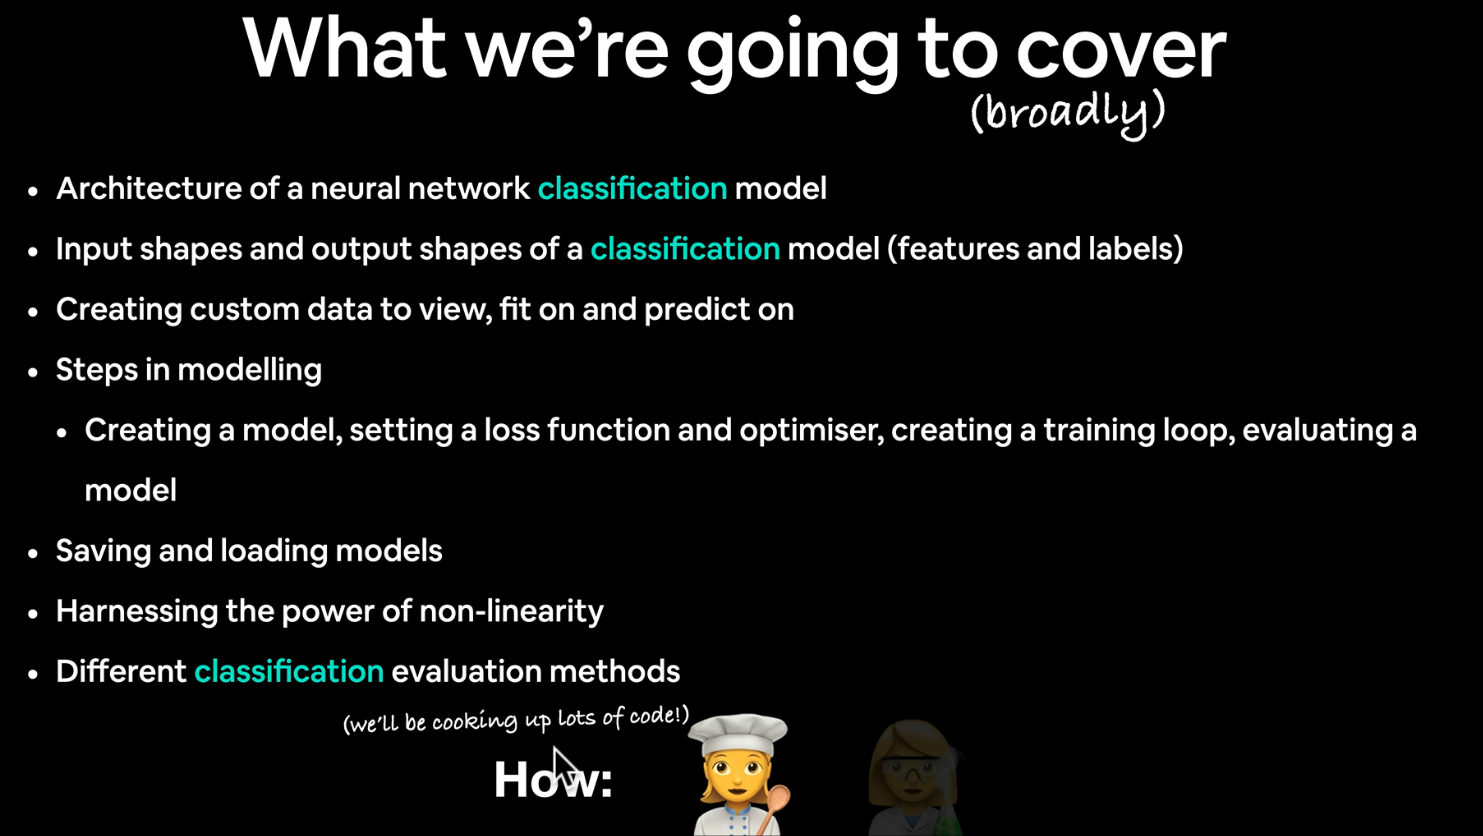


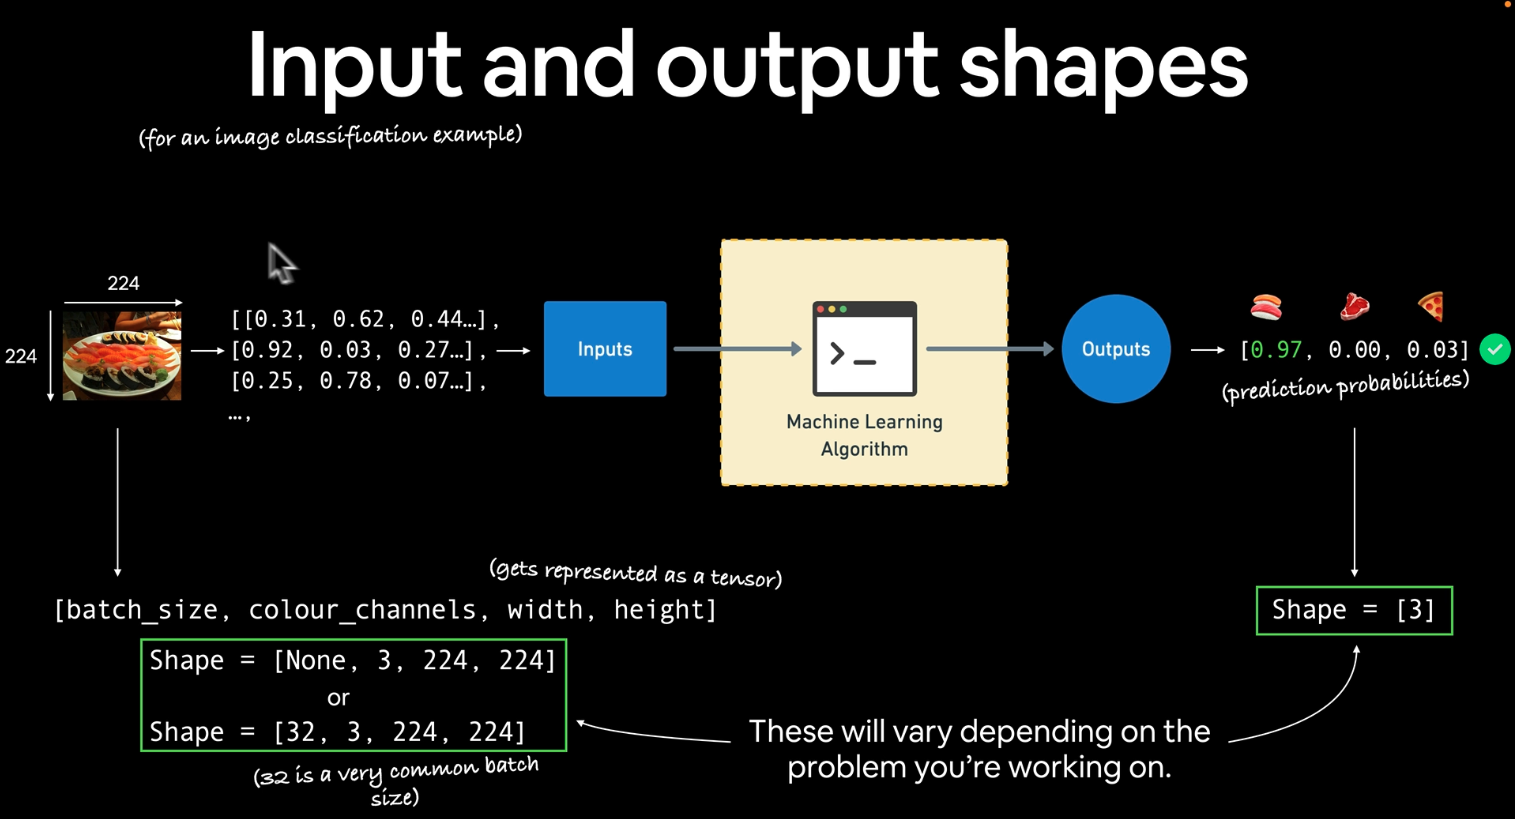

Shapes vary on the problem

Inputs are encoded numerical representation of data

Outputs are the prediction probability per class 

## 0) Overview: Typical Architecture of a Classification Neural Network

Hyperparameter = parameters that we decide the value of

Binary Classification = total number of outputs is 2, one or the other

Multiclass Classification = total number of outputs is 3 or more, more than one thing or another

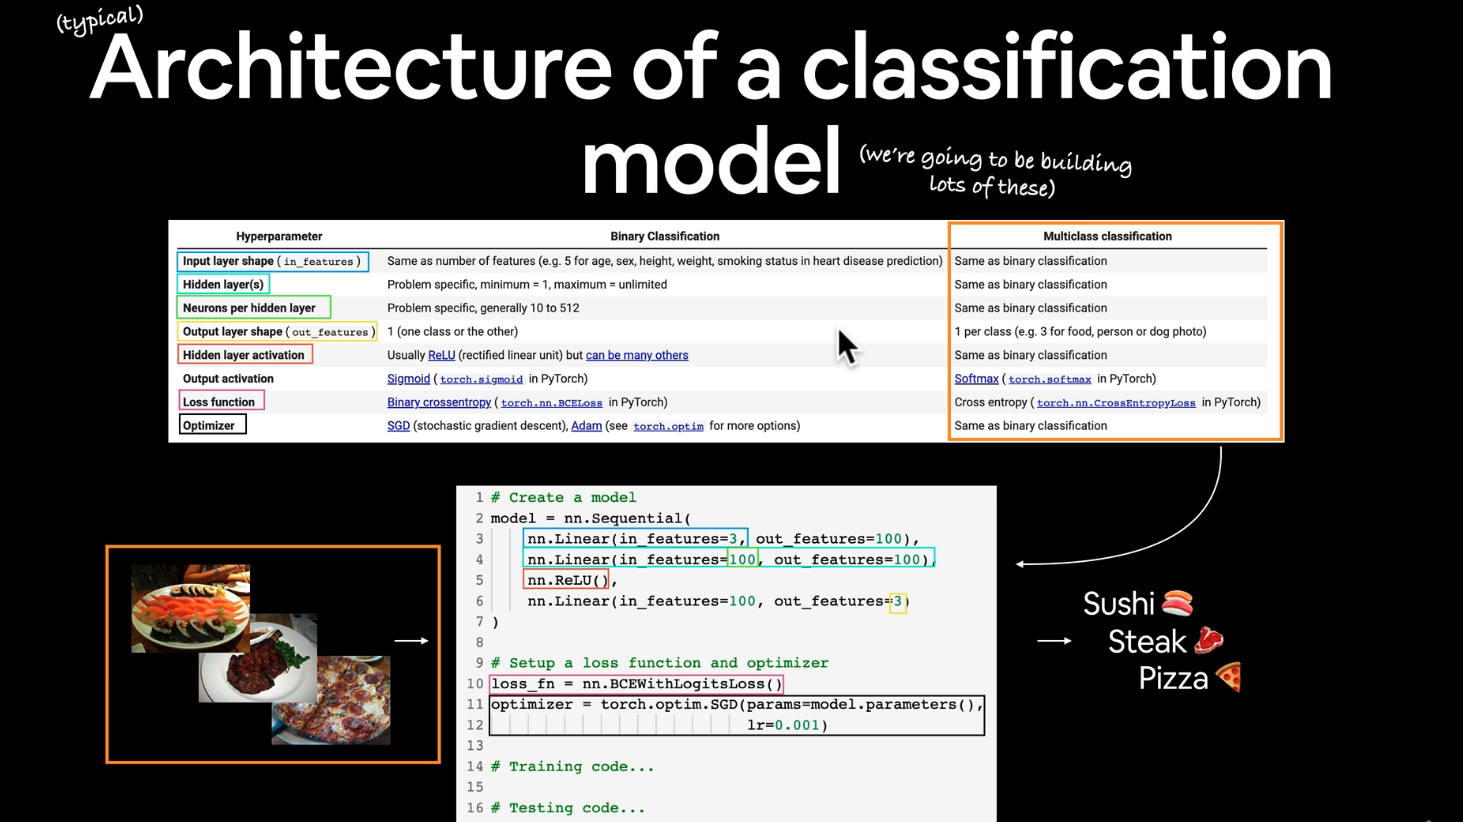

Next: The Flow
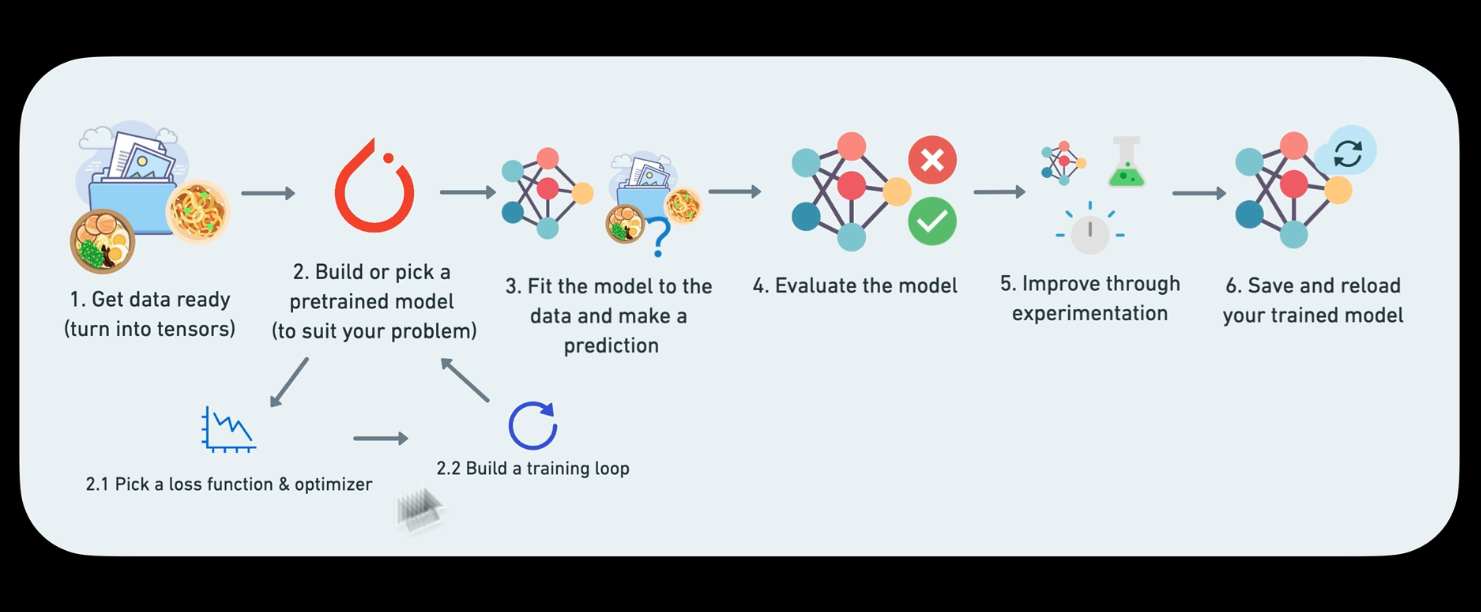

## 1) Make classification data and get it ready

`sklearn` a library for machine learning

<https://scikit-learn.org/stable/datasets/toy_dataset.html>

In Terminal:
        
        conda install scikit-learn

X is for tensors and labels

In [170]:
import sklearn

In [171]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples =1000

# create circles
X, y = make_circles(n_samples, 
                    noise=0.03, # increase randomness
                    random_state=42) # for reproducibility

In [172]:
len(X), len(y)

(1000, 1000)

In [173]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 labels of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 labels of y:
[1 1 1 1 0]


In [174]:
# Make DataFrame of Circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1], 
                        "label": y})
circles.head(10)

X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0

In [175]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

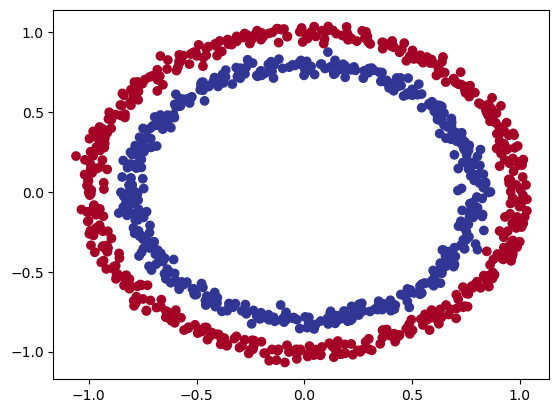

In [176]:
# Visualize, Visualize, Visualize!
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

**Note**: the data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [177]:
X.shape, y.shape

((1000, 2), (1000,))

In [178]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [179]:
import torch
torch.__version__

'2.4.0'

In [180]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float) #float is the same as float32
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [181]:
type(X), torch.float32, torch.float32

(torch.Tensor, torch.float32, torch.float32)

In [182]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

# NOTE: order of X and y is very important
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% of data to test set, 80% to train set
                                                    random_state=42)

In [183]:
print(f"Total samples in our data: {len(X)}")
print(f"Samples in train set: {len(X_train)}")
print(f"Samples in test set: {len(X_test)}")
print("\n")
print(f"Total labels in our data: {len(y)}")
print(f"Labels in train set: {len(y_train)}")
print(f"Labels in test set: {len(y_test)}")

Total samples in our data: 1000
Samples in train set: 800
Samples in test set: 200


Total labels in our data: 1000
Labels in train set: 800
Labels in test set: 200


## 2. Build a model

Let's build a model to classifiy our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [184]:
# import PyTorch and nn
import torch
from torch import nn

# For macbook m1 pro
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'cpu'

In [185]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Device Agnostic code set, now create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()`layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [186]:
X_train.shape

torch.Size([800, 2])

In [187]:
from sklearn import datasets
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        # Usually multiples of 8 for optimal performance
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feauture (same shape as y)

    # 3. Define the forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

# NOTE: We place it in a class so we can easily reuse it later by calling CircleModelV0()

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [188]:
device

'cpu'

In [189]:
next(model_0.parameters()).device

device(type='cpu')

<https://playground.tensorflow.org/>

In [190]:
# nn.Sequential(), another way to define the model we created above
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [191]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

Sequential() is an easier way to develop a striaght forward Neural Network

But as the model grows in complexity, we need to subclass (nn.Module)


In [192]:
# Make predictions with the model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 Labels: \n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 Labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [193]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

When we create our models and when we evaluate it, we want our predictions to be in the same format as our labels

### 2.1 Stepup Loss function and optimizer

Which loss function or optimizer should you use?

again... this is problem specific:
* For example, for regression you might want MAE or MSE
* For Classification, you might wanto binary cross entropy or categorical cross entrophy (cross entropy)

AS a reminder, a loss function measures how wrong our model's predictions are.

And for optimizers, two and the most common and useful are SGD and Adam, however PyTorch as many built in options.

* For some common choices of loss functions and optimizers - <https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer>
* For the loss function, we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - <https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a>
* for a definition on what a logit is in deep learning - <https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow>
* fpr different optimizers see `torch.optim`

In [194]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = binary cross-entropy loss, requires input to have gone through the sigmoid activation function pior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(model_0.parameters()
                            , lr=0.1) # SGD = stochastic gradient descent

In [195]:
# Calculate accuracy - out of 100 examples, what percentage does out model get right?
def accuracy_fn(y_true, y_pred):
    return torch.sum(y_true == torch.round(y_pred)).item() / len(y_true)

def accuracy_fn_1(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc


## 3. Train Model

To train our model, we're going to need to build a training loop with the following steps:
1. Forward Pass
2. Calculate the loss
3. Optimizer zero grad
4. loss backward (Backpropagation)
5. Optimizer (gradient descent)

### 3.1 Going from raw logits -> Prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**
* logits = raw outputs of our model without being passed to any activation function

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary crossentrophy and softmax for multiclass classification)

Then we can convert our models prediction probabilities to **prediction labels** by either rounding them or taking the `argmac()`.

In [196]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [197]:
# We need to pass the logits through a sigmoid function to get the predicted probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

For Our prediction probability values, we need to perform a range-style round on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` <0.5, `y=0` (class 0)


In [198]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In Full (Logits -> pred probs -> pred labels)
y_preds_full = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5])) # better to be in inference mode 

# check for equality
print(torch.eq(y_preds.squeeze(), y_preds_full.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [199]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a Training and test loop

In [200]:
torch.manual_seed(42)
torch.mps.manual_seed(42) # We don't need this but it's good to have for reproducibility

# Set the number of epochs
epochs = 100

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loops
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> Pred Probs -> Pred Labels

    # 2. Calculate Loss/Accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects pred probs as inputs
    loss = loss_fn(y_logits, ## nn.BCEWithLogitsLoss expects 
                     y_train)
    acc = accuracy_fn_1(y_true = y_train , # nn.BCEWithLogitsLoss expects raw logits as input
                       y_pred = y_pred)
    
    # 3. Optimizer Zero the gradients
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Step (update weights) optimizer (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test Loss/Accuracy
        test_loss = loss_fn(test_logits, 
                            y_test)
        
        test_acc = accuracy_fn_1(y_true = y_test,
                                y_pred = test_pred)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.2f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.70 | Train Acc: 51.88% | Test Loss: 0.69 | Test Acc: 58.00%
Epoch: 10 | Train Loss: 0.70 | Train Acc: 51.25% | Test Loss: 0.69 | Test Acc: 53.00%
Epoch: 20 | Train Loss: 0.69 | Train Acc: 51.62% | Test Loss: 0.69 | Test Acc: 49.50%
Epoch: 30 | Train Loss: 0.69 | Train Acc: 51.12% | Test Loss: 0.69 | Test Acc: 49.50%
Epoch: 40 | Train Loss: 0.69 | Train Acc: 50.88% | Test Loss: 0.69 | Test Acc: 51.00%
Epoch: 50 | Train Loss: 0.69 | Train Acc: 50.25% | Test Loss: 0.69 | Test Acc: 50.00%
Epoch: 60 | Train Loss: 0.69 | Train Acc: 50.00% | Test Loss: 0.69 | Test Acc: 51.50%
Epoch: 70 | Train Loss: 0.69 | Train Acc: 50.25% | Test Loss: 0.69 | Test Acc: 51.00%
Epoch: 80 | Train Loss: 0.69 | Train Acc: 49.88% | Test Loss: 0.69 | Test Acc: 50.00%
Epoch: 90 | Train Loss: 0.69 | Train Acc: 49.88% | Test Loss: 0.69 | Test Acc: 53.00%


In [201]:
loss_fn # More numerically stable than BCELoss()

BCEWithLogitsLoss()

## 4. Make predictions and evaluate the model

From the metrics it looks like out model isn't learning anything..

So to inspect it  let's make some predictions and make them visual.

In other words : "Visualize, visualize, visualize!

To do so, we're going to import a function called `plot_decision_boundary()` 
* <https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py>

A great resource: <https://madewithml.com/>

In [202]:
import requests
from pathlib import Path

# Download helper functions from PyTorch repo (if it's not already downloaded)
if Path("help_functions.py").is_file():
    print("helper_functions.py already exists, skipping download.")
else:
    print("Downloading help_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


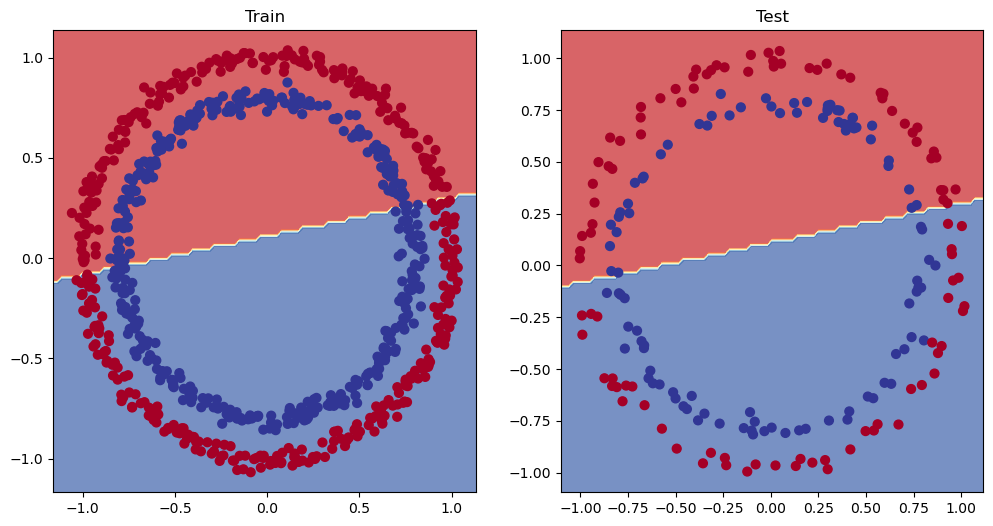

In [203]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_0, 
                       X=X_train, 
                       y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, 
                       X_test, 
                       y_test)

## 5. Improving a model (from a model perspective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer (more epochs)
* Changing the activation function (we're using sigma right now)
    * however, we can put more activation models within our model
* Change the learning rate
* Change the loss function

These models are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to as **hyperparameters**
* Parameters are numbers within a model in which the model updates by itself

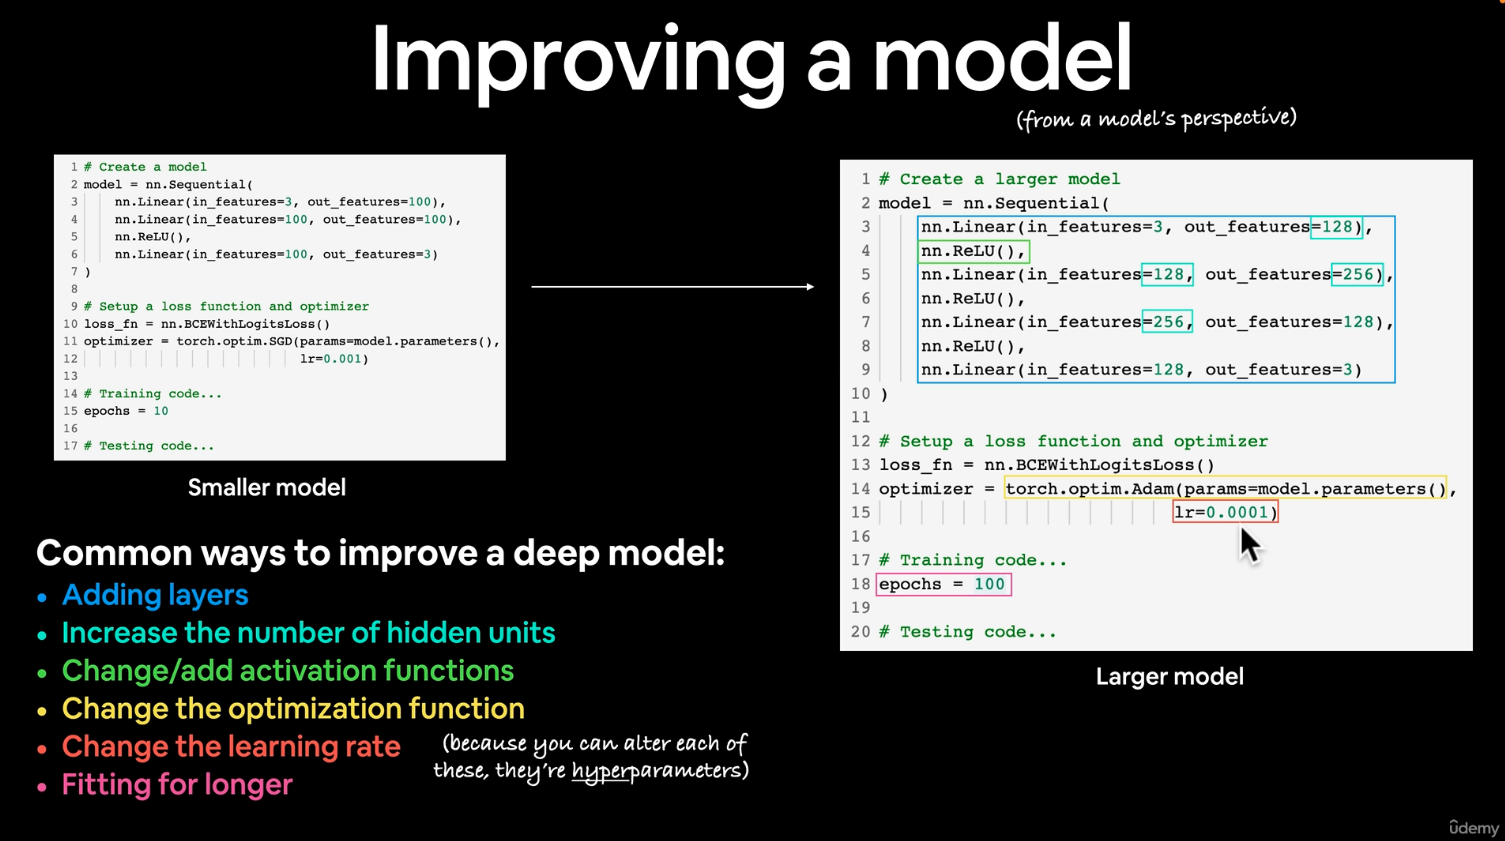

Let's try to improve our model by:
* Adding more hidden units: 5->10
* Increase the number of layers: 2-> 3
* Increase the number of epochs: 100 -> 1000

**NOTE** !!! :  this is just an example. IN reality, you would try to improve your model with one change at a time to see which is actually being effective.



In [204]:
print(f"Starts with 2 becasue we have 2 features: {X_train.shape}")
print(f"Ends with 1 because we have 1 output: {y_train.shape}")

Starts with 2 becasue we have 2 features: torch.Size([800, 2])
Ends with 1 because we have 1 output: torch.Size([800])


In [205]:
# Create a BETTER Model
class CircleModelV1(nn.Module):
    def __init__ (self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # Start with 2
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1) # End with 1
    
    # def forward(self, x):
    #     # Passing our data through each layer
    #     z = self.layer_1(x)
    #     z = self.layer_2(z)
    #     z = self.layer_3(z)
    #     return z

    # Faster Way
    def forward(self, x): # This way of writing operations leverages speed ups where possible behind the scenes
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1   

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [206]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

In [207]:
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [208]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.mps.manual_seed(42)

In [209]:
# Train for Longer
epochs = 1000

In [210]:
# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [211]:
### TRAINING
for epoch in range(epochs):
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> Pred Probs -> Pred Labels
    # 2. Calculate Loss/Accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                        y_pred = y_pred)
    # 3. Optimizer Zero the gradients
    optimizer.zero_grad()
    # 4. loss backward (backpropagation)
    loss.backward()

     ### TESTING
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate test Loss/Accuracy
        test_loss = loss_fn(test_logits, 
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                                y_pred = test_pred)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 100 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 200 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 300 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 400 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 500 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 600 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 700 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 800 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%
Epoch: 900 | Train Loss: 0.69396 | Train Acc: 0.51% | Test Loss: 0.69261 | Test Acc: 0.51%


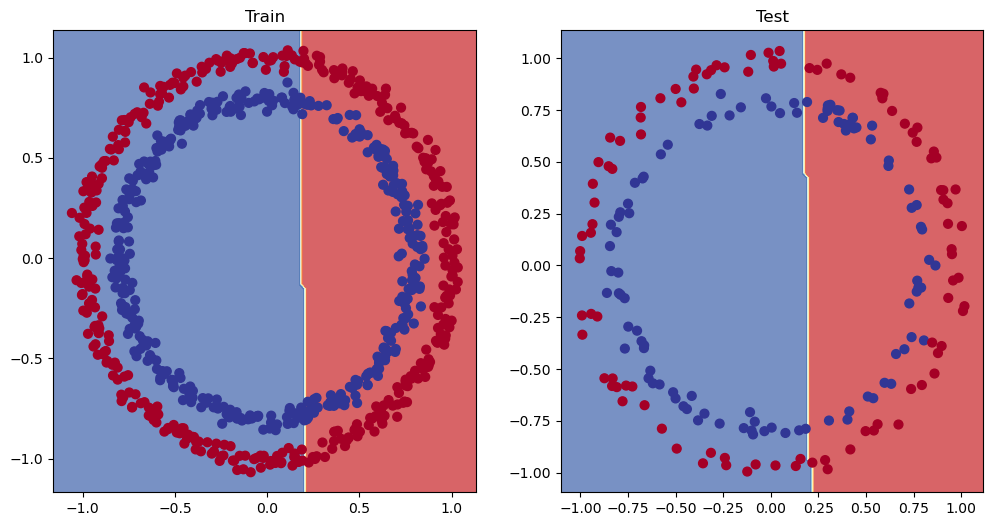

In [212]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_1, 
                       X=X_train, 
                       y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, 
                       X_test, 
                       y_test)

### 5.1 Preparing data to see if our model can firt a striaght line 

One way to troubleshoot a larger problem is to a test out a smaller problem

In [213]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start,end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias  # Linear regression formula (without epsilon)

# Check the data
print(f"X_regression: length {len(X_regression)},\nFirst 5 values: \n {X_regression[:5], y_regression[:5]}")

X_regression: length 100,
First 5 values: 
 (tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]), tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]]))


In [214]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data to training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

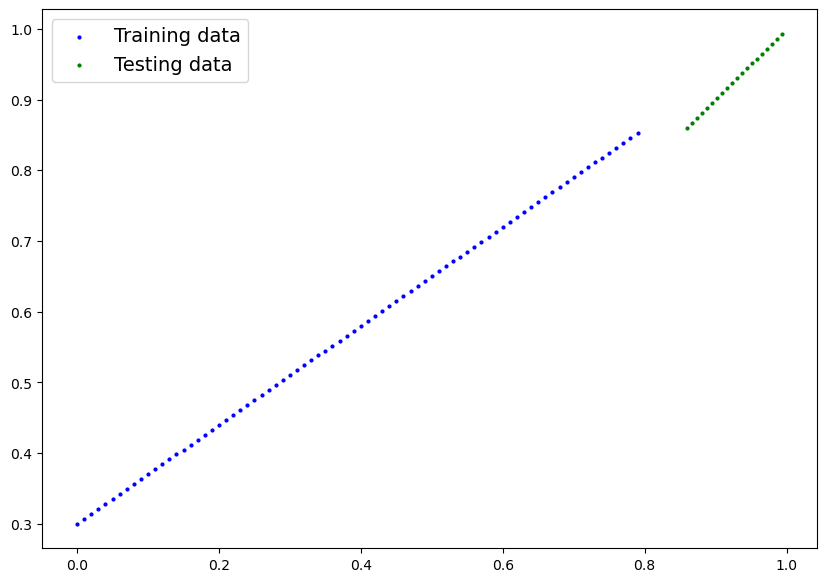

In [215]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=y_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a striaght line


In [216]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features =1, out_features=10),
    nn.Linear(in_features =10, out_features=10),
    nn.Linear(in_features =10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [217]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                            lr=0.01)

In [218]:
# Train the model
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data to the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    # 2. Calculate Loss
    loss = loss_fn(y_pred, y_train_regression)
    # 3. Zero the gradients
    optimizer.zero_grad()
    # 4. Backward pass
    loss.backward()
    # 5. Step (update weights)
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_loss = loss_fn(model_2(X_test_regression), y_test_regression)
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Train Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Train Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Train Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Train Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Train Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Train Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Train Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Train Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Train Loss: 0.01798 | Test Loss: 0.00360


In [219]:
# Turn on evaluation mode
model_2.eval()

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [220]:
# Make predictions (Inference)
with torch.inference_mode():
    y_preds_regression = model_2(X_test_regression)

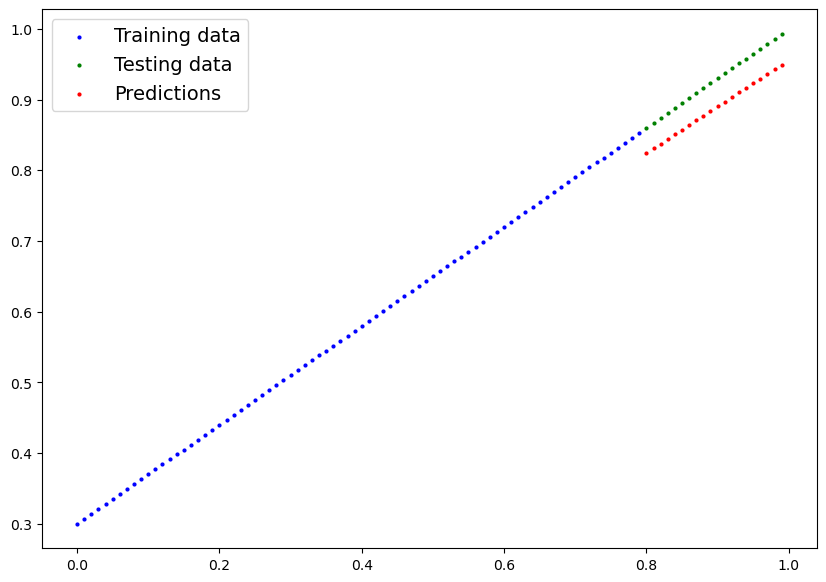

In [221]:
# Plot data and predictions
plot_predictions(train_data= X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds_regression.cpu())

## 6. The Missing Piece: Non-Linearity

What patterns could you draw if you were given an infintie amount of striaght and on-striaght lines?

Or in Machine Learning terms, an infinite (but really it is finite) of linear and non-linear functions


### 6.1 Recreating non-linear data (red and blue circles)

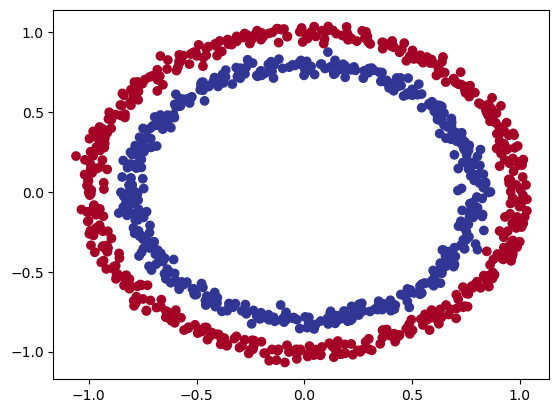

In [222]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)



In [223]:
## Convert data to tensors and the to train and test splits
import torch
from sklearn.model_selection import train_test_split

In [224]:
# Turn data in tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [225]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [226]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

All modules in torch.nn are some form of layer: Input, hidden, or output

The hidden layers can be almost any combination of what's in torch.nn or cominbination of function -- Whether they work or not is another question-- They all have the same premise: perform some sort of mathematical operation on an input:

https://pytorch.org/docs/stable/nn.html

In [227]:
# A model with on-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # NOTE: New
        self.relu = nn.ReLU() # ReLU is a non-linear activation function
    
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [228]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), 
                            lr=0.01)

### 6.3 Training a Model with non-linearity

with relu

In [229]:
# Random Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on the target device (device agnostic code) 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):

    ### Training
    model_3.train()
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> Pred Probs -> Pred Labels
    # 2. Calculate Loss
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true = y_train, 
                      y_pred = y_pred)
    # 3. Zero gradients
    optimizer.zero_grad()
    # 4. Backward pass (calculate gradients)
    loss.backward()
    # 5. Step the optimzer (update weights)
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, 
                              y_pred = test_pred)
    
    ### Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.6929, Acc: 0.50% | Test Loss: 0.69325, Test Acc: 0.50%
Epoch: 100 | Train Loss: 0.6925, Acc: 0.50% | Test Loss: 0.69264, Test Acc: 0.50%
Epoch: 200 | Train Loss: 0.6922, Acc: 0.59% | Test Loss: 0.69233, Test Acc: 0.56%
Epoch: 300 | Train Loss: 0.6921, Acc: 0.70% | Test Loss: 0.69214, Test Acc: 0.67%
Epoch: 400 | Train Loss: 0.6919, Acc: 0.68% | Test Loss: 0.69197, Test Acc: 0.70%
Epoch: 500 | Train Loss: 0.6918, Acc: 0.58% | Test Loss: 0.69179, Test Acc: 0.62%
Epoch: 600 | Train Loss: 0.6917, Acc: 0.54% | Test Loss: 0.69163, Test Acc: 0.56%
Epoch: 700 | Train Loss: 0.6915, Acc: 0.53% | Test Loss: 0.69148, Test Acc: 0.53%
Epoch: 800 | Train Loss: 0.6914, Acc: 0.53% | Test Loss: 0.69133, Test Acc: 0.53%
Epoch: 900 | Train Loss: 0.6913, Acc: 0.53% | Test Loss: 0.69118, Test Acc: 0.53%


### 6.4 Evaluating a model trained with non-linear activation functions


In [230]:
# Make Predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

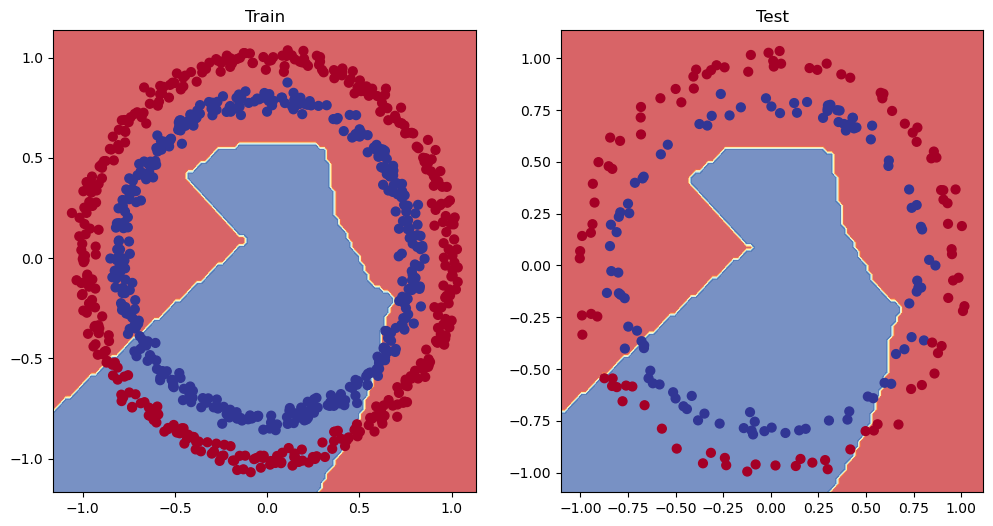

In [231]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_3, 
                       X=X_train, 
                       y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, 
                       X_test, 
                       y_test)


## 7. Replication non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And These tools are linear and & non-linear functions. For all models of all sizes

PyTorch Layers can be coded but it is better to use PyTorch version if available


In [232]:
# Create a tensor
A = torch.arange(-10, 10, 1 , dtype=torch.float32)
# NOTE: PyTorch default data type for integers is int64
A.dtype

torch.float32

In [233]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

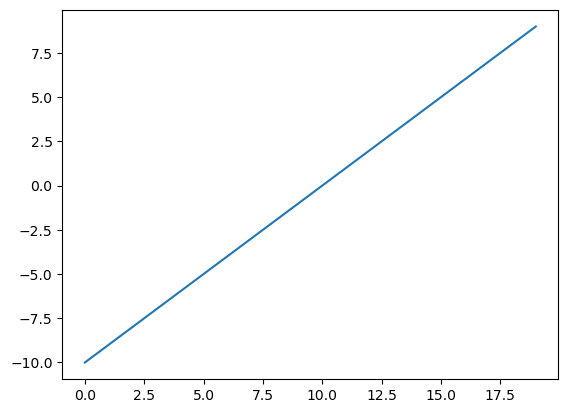

In [234]:
# Visualize the tensor
plt.plot(A);

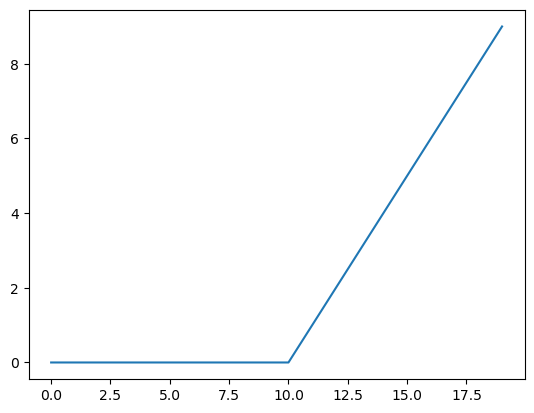

In [235]:
# ReLU on linear functions
plt.plot(torch.relu(A));

In [236]:
# ReLU turns all negative numbers to 0 and keeps positive numbers the same
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(x, torch.tensor(0)) #inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

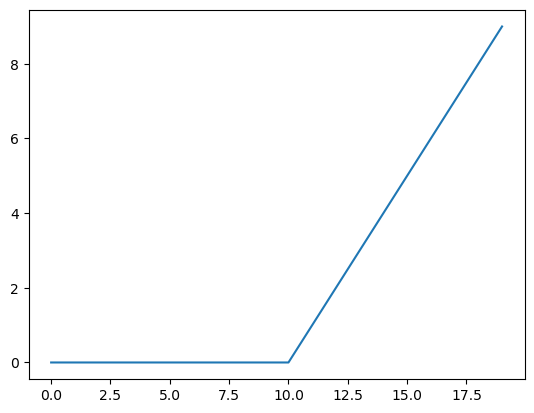

In [237]:
# Plot ReLU activation function
plt.plot(relu(A));
# Same as torch.relu(A)

In [238]:
# Now let's do the same for Sigmoid
def sigmoid(A):
    return 1 / (1 + torch.exp(-A))

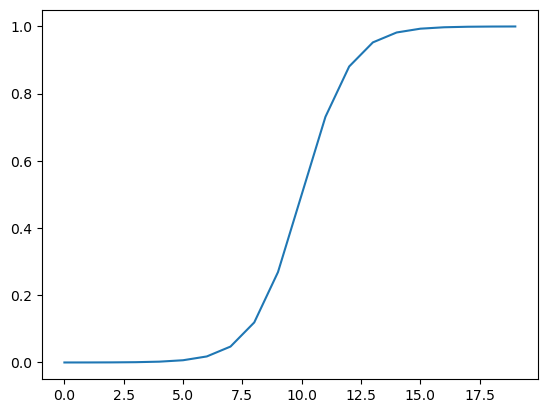

In [239]:
plt.plot(torch.sigmoid(A));

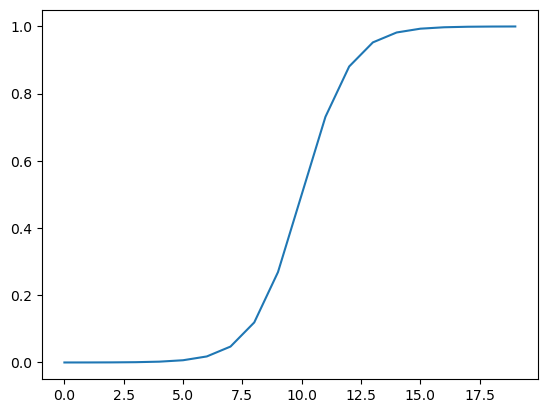

In [240]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog, spam vs not-spam)
* Multi-class classification = mornting than one thing or another ( cat vs dog vs chicken vs... vs n)

Hyperparameters at the start of a notebook are usually writen in ALL_CAPS. This indicates that they settings one can change.

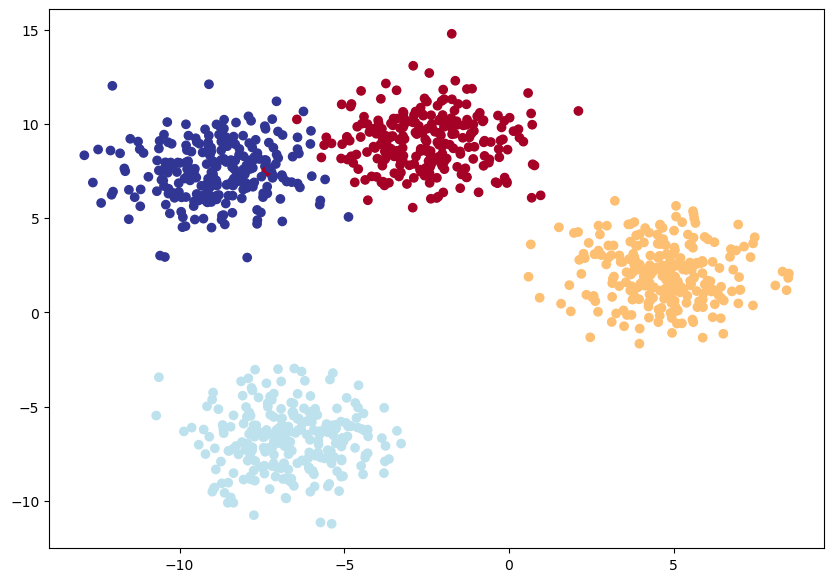

In [241]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, 
                            centers=NUM_CLASSES, 
                            n_features=NUM_FEATURES, 
                            random_state=RANDOM_SEED,
                            cluster_std=1.5 # gives the clusters a little shake up
                            )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) 

# 3. Split data into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)

# 4. PLot the data (visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [242]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [243]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        # let future developers know what's going on
        """Initializes mult-class classification model.
        
        Args:
        input_features: int, number of input features
        output_features: int, number of output features (number of output classes)
        hidden_units: int, number of hidden units between layers, default 8

        Returns: BLAH BLAH

        Example: blah blah
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features =hidden_units),
            nn.ReLU(), # add non-linearity
            nn.Linear(in_features=hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features= output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [244]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [245]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer for multi-class classification model

In [246]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss expects raw logits as input

# Create an optimizer - optimizer updates our model's parameters to try to reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.01) #learning rate is a hyperparameter that you can change

### 8.4 Getting prediction probabilities for multi-class PyTorch Model

in order to evalute and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred Probs (use `torch.softmax`) -> Pred Labels (take argmax of the prediction probabilities)

<https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html>

In [247]:
# Let's get some raw outputs of our model 
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_train.to(device))

y_logits[:10]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923],
        [-0.2044, -1.1380, -0.9468, -0.3093],
        [-0.2613, -1.2852, -1.0251, -0.2935],
        [-0.5237, -0.5791, -1.1276, -0.8689],
        [-0.0423, -0.8228, -0.4666, -0.0986],
        [-0.1876, -1.1245, -0.8498, -0.2406]], device='cuda:0')

In [248]:
# We need to get y_logits to the same format as y_blob_test
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [249]:
# Covert our model's logit outpits to prediction probabilities
y_preds_probs = torch.softmax(y_logits, dim=1) # softmax converts raw model outputs to probabilities
print(y_logits[:5])
print(y_preds_probs[:5])

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0')
tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]], device='cuda:0')


In [250]:
torch.sum(y_preds_probs[0])

tensor(1.0000, device='cuda:0')

In [251]:
torch.max(y_preds_probs[0])

tensor(0.3328, device='cuda:0')

In [252]:
# Our model's prediction for the first sample
torch.argmax(y_preds_probs[0])

tensor(1, device='cuda:0')

In [253]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_preds_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
        3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch Model

In [254]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Training loop
for epoch in range(epochs):
    ### Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train) # CrossEntropyLoss expects raw logits as input
    acc = accuracy_fn(y_true = y_blob_train, 
                      y_pred = y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test, 
                               y_pred = test_preds)
        
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 1.1588, Train Acc: 0.40% | Test Loss: 1.1472, Test Acc: 0.39%
Epoch: 10 | Train Loss: 1.0649, Train Acc: 0.55% | Test Loss: 1.0684, Test Acc: 0.51%
Epoch: 20 | Train Loss: 0.9819, Train Acc: 0.63% | Test Loss: 0.9976, Test Acc: 0.57%
Epoch: 30 | Train Loss: 0.9114, Train Acc: 0.70% | Test Loss: 0.9360, Test Acc: 0.67%
Epoch: 40 | Train Loss: 0.8529, Train Acc: 0.88% | Test Loss: 0.8834, Test Acc: 0.88%
Epoch: 50 | Train Loss: 0.8043, Train Acc: 0.92% | Test Loss: 0.8385, Test Acc: 0.93%
Epoch: 60 | Train Loss: 0.7635, Train Acc: 0.94% | Test Loss: 0.7998, Test Acc: 0.94%
Epoch: 70 | Train Loss: 0.7285, Train Acc: 0.95% | Test Loss: 0.7659, Test Acc: 0.95%
Epoch: 80 | Train Loss: 0.6977, Train Acc: 0.96% | Test Loss: 0.7356, Test Acc: 0.95%
Epoch: 90 | Train Loss: 0.6698, Train Acc: 0.96% | Test Loss: 0.7076, Test Acc: 0.96%
Epoch: 100 | Train Loss: 0.6438, Train Acc: 0.97% | Test Loss: 0.6812, Test Acc: 0.97%
Epoch: 110 | Train Loss: 0.6191, Train Acc: 0.98% | Te